In [4]:
import numpy as np
import scipy as sp
from PIL import Image

import matplotlib.pylab as plt
import matplotlib.animation as animation
from matplotlib.lines import Line2D

import scipy.stats as st
from sortedcontainers import SortedDict
from skimage.restoration import unwrap_phase

from IPython.display import HTML

import math
import random
import opticspy as opy

from scipy.optimize import curve_fit, minimize

In [99]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 10)

Populating the interactive namespace from numpy and matplotlib


In [30]:
def show_wave(wave):
    fig,ax = plt.subplots(1,2)
    ax1 = ax[0]
    ax2 = ax[1]

    ax[0].set_title("Magnitude")
    ax[1].set_title("Phase")
    
    wave_abs = np.abs(wave)
    wave_phase = np.angle(wave)
        
    plt1 = ax1.imshow(wave_abs)
    plt2 = ax2.imshow(wave_phase)

In [24]:
class WaveAnimation(animation.TimedAnimation):
    def __init__(self,data):
        fig,ax = plt.subplots(1,2)
        self.ax1 = ax[0]
        self.ax2 = ax[1]
        
        ax[0].set_title("Magnitude")
        ax[1].set_title("Phase")
        
        self.data = data
        self.t = len(data)

        animation.TimedAnimation.__init__(self, fig, interval=1000, blit=True)

    def _draw_frame(self, framedata):
        i = framedata-1
        wave_abs = np.abs(self.data[i])
        wave_phase = np.angle(self.data[i])
        
        plt1 = self.ax1.imshow(wave_abs)
        plt2 = self.ax2.imshow(wave_phase)
        self._drawn_artists = [plt1,plt2]

    def new_frame_seq(self):
        return iter(range(self.t))

    def _init_draw(self):
        wave_abs = np.abs(self.data[0])
        wave_phase = np.angle(self.data[0])
        
        plt1 = self.ax1.imshow(wave_abs)
        plt2 = self.ax2.imshow(wave_phase)
        
    def close(self):
        plt.close()

In [5]:
def get_kernel(wavelength,z,dx,dy,x,y):
    kernelFactor = 2*math.pi*z/wavelength
    
    dfx = 1/(dx*x)
    dfy = 1/(dy*y)
    
    # Count up then down eg: [0,1,2,1,0]
    if x % 2 == 0:
        x2 = np.append(np.arange(x/2),np.flip(np.arange(x/2)))
    else:
        x2 = np.append(np.arange((x/2)-1),[math.ceil(x/2)])
        x2 = np.append(x2,np.flip(np.arange((x/2)-1)))
        
    if y % 2 == 0:
        y2 = np.append(np.arange(y/2),np.flip(np.arange(y/2)))
    else:
        y2 = np.append(np.arange((y/2)-1),[math.ceil(y/2)])
        y2 = np.append(y2,np.flip(np.arange((y/2)-1)))
    
    l = x2 - (x/2) + 1
    l2 = (l**2) * (dfx**2)
    
    m = y2 - (y/2) + 1
    m2 = (m**2) * (dfy**2) + 1
    
    l2 = np.arange(x)-int(x/2)
    m2 = np.arange(y)-int(y/2)
    
    l3 = np.broadcast_to(l2, (y,x)).transpose()
    m3 = np.broadcast_to(m2, (x,y))
    
    kernelPhase = np.power(1 - (wavelength*l3/dx)**2 - (wavelength*m3/dy)**2,(1/2)) * kernelFactor
    
    real = np.cos(kernelPhase)
    img = 1j*np.sin(kernelPhase)
    
    return real+img

(300, 250)


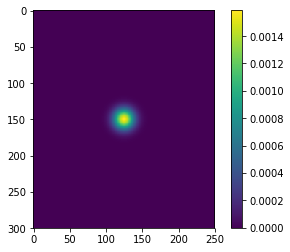

In [6]:
# https://stackoverflow.com/questions/28342968/how-to-plot-a-2d-gaussian-with-different-sigma

#TODO: Get sigma, size right
def generate_gaussian_grid(size_x,size_y,sigma_x=3.,sigma_y=3.):
    #size_x *= 2
    #size_y *= 2
    
    x = np.linspace(-int(size_x/2), int(size_x/2), size_x)
    y = np.linspace(-int(size_y/2), int(size_y/2), size_y)

    x, y = np.meshgrid(x, y)
    z = (1/(2*np.pi*sigma_x*sigma_y) * np.exp(-(x**2/(2*sigma_x**2) + y**2/(2*sigma_y**2))))
    #plt.contourf(x, y, z, cmap='Blues')
    #plt.colorbar()
    #plt.show()
    
    #z = z[int(size_y/2):,:int(size_x/2)].transpose()
    
    return z

#print(z.shape)

#plt.contourf(x, y, z, cmap='Blues')
#plt.colorbar()
#plt.show()

gauss = generate_gaussian_grid(250,300,10,10)
plt.imshow(gauss)
plt.colorbar()
#plt.hist(gauss.flatten(),50)
print(gauss.shape)

-9.549694368615746e-16
1.0


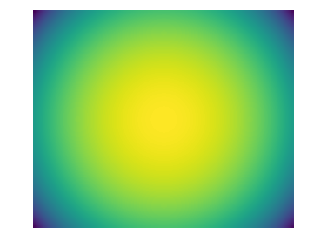

In [7]:
def gen_sphere(x,y,r=50):
    #x *= 2
    #y *= 2
    circ = np.zeros((x,y))

    r2 = np.power(r,2)
    
    pos_x = x/2
    pos_y = y/2
    
    for i in range(x):
        x2 = np.power(i-pos_x,2)
        for j in range(y):
            
            circ[i][j] = np.power(max(0,r2-(x2+np.power(j-pos_y,2))),1/2)
            
    circ = sp.ndimage.filters.gaussian_filter(circ,sigma=3)
    
    mean = np.mean(circ)
    sd = np.std(circ)
    
    circ = (circ-mean)/sd
    
    return circ

sphere = gen_sphere(250,300,200)
plt.imshow(sphere)
plt.axis('off')

print(np.mean(sphere))
print(np.std(sphere))

In [80]:
def get_gauss_beam(x,y):
    #gauss = generate_gaussian_grid(x,y,x*0.05,y*0.05).transpose()
    #sphere = gen_sphere(x,y,x*0.05)
    gauss = generate_gaussian_grid(x,y,x*0.2,y*0.2).transpose()
    sphere = gen_sphere(x,y,x*0.2)
    gauss = gauss * (np.cos(sphere) + 1j*np.sin(sphere))
    #gauss = gauss * (np.cos(np.ones((x,y))) + 1j*np.sin(np.ones((x,y))))
    return gauss

In [9]:
# https://stackoverflow.com/questions/12141150/from-list-of-integers-get-number-closest-to-a-given-value
def takeClosest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        before = None
        after = None
    elif pos == len(myList):
        before = myList[-1]
        after = None
    else:
        before = myList[pos - 1]
        after = myList[pos]
    
    return before, after

'''
    0 - reject
    1 - accept
    2 - unsure
'''
def check(keys,sd,uni,sam):
    hi = len(keys)
    lo = 0
    
    if hi == 1:
        return 2
    
    if hi == 2:
        if keys[0] < uni and sam > sd.get(keys[0]):
            return 0
            
        if keys[1] > uni and sam < sd.get(keys[1]):
            return 1
        return 2
        
    
    while lo < hi:
        mid = (lo+hi)//2
        mk = keys[mid]
        if mk < uni and sam > sd.get(mk):
            return 0
        if mid < (hi-1):    
            mk2 = keys[mid+1]
            if mk2 > uni and sam < sd.get(mk2):
                return 1
        
        if mk < uni: lo = mid+1
        else: hi = mid
    return 2

In [111]:
class speckle_noise(st.rv_continuous):
    mu = 0.995
    sd = SortedDict([])
    
    def _pdf(self,epsilon):
        b = np.abs(self.mu) * np.cos(epsilon)
        f = (1-np.power(np.abs(self.mu),2))/(2*np.pi)
        g = np.power(1-np.power(b,2),(-3/2))
        h = (b * np.arcsin(b))+((np.pi*b)/2) + np.power(1-np.power(b,2),(1/2))

        return f*g*h
        
    def rvs(self,size):
        res = []
        pdf = self._pdf(0)
        
        self.sd.update([(0,pdf)])
        self.keys = list(self.sd.keys())
        
        while len(res) < size:
            uni = np.random.uniform(0,self.b) # Since the function is mirrored around 0
            sam = np.random.uniform(0,pdf)
            
            c = check(self.keys,self.sd,uni,sam)
            
            if c == 0:
                continue
            if c == 1:
                sign = np.random.randint(2)+1
        
                res.append(uni*((-1)**sign))
                continue
            
            pdf_val = self._pdf(uni)
            if sam < pdf_val:
                sign = np.random.randint(2)+1
        
                res.append(uni*((-1)**sign))
                self.sd.update([(uni,pdf_val)])
                self.keys = list(self.sd.keys())

        return np.array(res)

noise_dist = speckle_noise(a=-math.pi, b=math.pi, name='speckle')
    
def generate_noise(x,y):
    noise = noise_dist.rvs(size=(x*y))
    noise = noise.reshape((x,y))
    
    return noise

(array([1.6500e+02, 0.0000e+00, 0.0000e+00, 1.9500e+02, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 7.2000e+01, 7.5000e+01,
        3.6000e+01, 1.4400e+02, 0.0000e+00, 4.4200e+02, 7.0600e+02,
        9.1500e+02, 2.8180e+03, 7.2130e+03, 1.4729e+04, 2.4829e+04,
        1.1662e+04, 5.9060e+03, 2.1980e+03, 1.7840e+03, 1.2730e+03,
        1.7300e+02, 0.0000e+00, 1.9300e+02, 2.1200e+02, 0.0000e+00,
        4.9000e+01, 0.0000e+00, 0.0000e+00, 1.1900e+02, 3.2000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        1.1700e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.1700e+02]),
 array([-1.98874587, -1.88621751, -1.78368916, -1.68116081, -1.57863245,
        -1.4761041 , -1.37357574, -1.27104739, -1.16851903, -1.06599068,
        -0.96346232, -0.86093397, -0.75840561, -0.65587726, -0.5533489 ,
        -0.45082055, -0.34829219, -0.24576384, -0.14323548, -0.04070713,
         0.06182123,  0.16

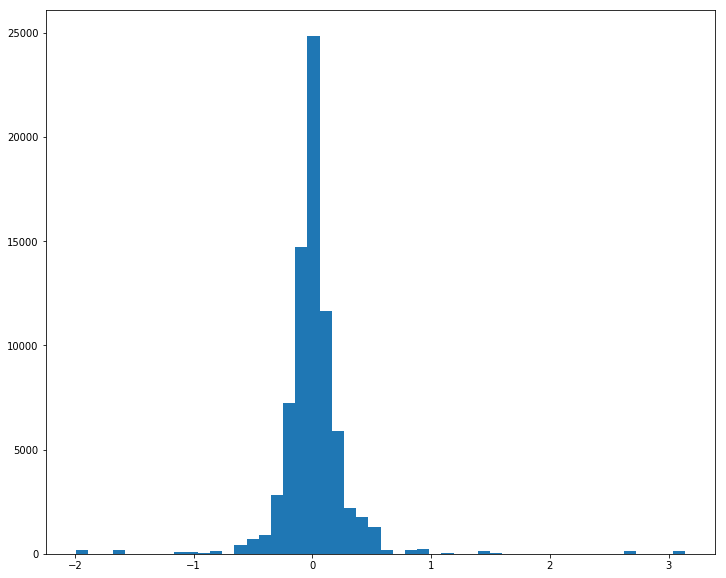

In [113]:
x = 276
y = 276
max_size = 20

def gen_rand_sizes(i):
    sum_i = 0
    list_i = []
    
    while sum_i < (i-1):
        r = random.randint(1,min(max_size,i-(sum_i-1)))
        list_i.append(r)
        sum_i+=r
        
    return list_i

def gen_noise_random_size(x,y):
    x_list = gen_rand_sizes(x)
    y_list = gen_rand_sizes(y)
    
    noise = noise_dist.rvs(size=(len(x_list)*len(y_list)))
    #noise = np.random.exponential(size=(len(x_list)*len(y_list)))
    
    noise_mat = np.zeros((x,y))
    
    current_x = 0
    current_y = 0
    
    noise_counter = 0
    
    for block_x in x_list:
        current_y = 0
        for block_y in y_list:
            noise_mat[current_x:current_x+block_x,current_y:current_y+block_y] = noise[noise_counter]
            current_y += block_y
            noise_counter += 1
        current_x += block_x
            
    #noise_mat = sp.ndimage.filters.gaussian_filter(noise_mat,sigma=3)
    
    mean = np.mean(noise_mat)
    sd = np.std(noise_mat)
    
    noise_mat = (noise_mat-mean)/np.max(noise_mat)
    noise_mat *= np.pi
            
    return noise_mat
            
#plt.imshow(gen_noise_random_size(x,y))
np.mean(np.abs(gen_noise_random_size(x,y)+1))
n=gen_noise_random_size(x,y)
phase = np.angle(np.cos(n) + 1j*np.sin(n))
#plt.imshow(phase)
plt.hist(phase.flatten(),50)
#plt.axis('off')

In [53]:
def get_diffracted(in_beam,aperture_beam,dist,wavelength):
    f = in_beam*aperture_beam
    
    wave_dist = dist*wavelength
    kernel = get_kernel(wavelength,dist,x,y,x,y)
    
    fft_diffracted = np.fft.fftshift(np.fft.fft2(f)) * kernel
    diffracted = np.fft.ifft2(np.fft.ifftshift(fft_diffracted))
    #fft_aperture = np.fft.fftshift(np.fft.fft2(in_beam/wave_dist))
    #diffracted = (np.power(np.abs(in_beam),2)/np.power(wave_dist,2)) * np.power(fft_aperture,2)
    
    return diffracted

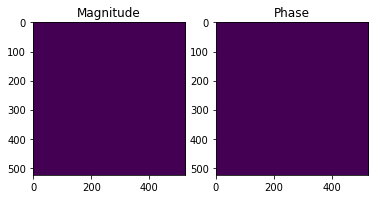

In [56]:
kernel = get_kernel(wavelength,0,x,y,x,y)
show_wave(kernel)

In [93]:
#Test rect aperture
x=10000
y=10001
wavelength = 0.525
dist=200

in_beam = get_gauss_beam(x,y)
#in_beam = np.cos(np.zeros((x,y))) + 1j*np.sin(np.zeros((x,y)))
aperture = np.zeros((x,y))
aperture[230:300,230:300] = 1

diffracted = get_diffracted(in_beam,aperture,dist,wavelength)

#plt.imshow(aperture)
show_wave(diffracted)

KeyboardInterrupt: 

In [ ]:
#Test gauss beam + noise
x = 10000
y = 10001
dist = 100
wavelength = 0.525

num_imgs = 5

gauss = get_gauss_beam(x,y)
noise = gen_noise_random_size(x,y)
noise_ap = (np.cos(noise) + 1j*np.sin(noise)) #* (1 - ())

noises = []
for i in range(num_imgs):
    n = gen_noise_random_size(x,y)
    n_ap = (np.cos(noise) + 1j*np.sin(noise))
    noises.append(n_ap)

In [ ]:
#noise = np.zeros((x,y))
comb = get_diffracted(gauss,noise_ap,dist,wavelength)

combs = [comb]

for i in range(num_imgs):
    combs.append(get_diffracted(combs[i],noises[i],dist,wavelength))

print()
#wave = gen_noise_random_size(x,y)

In [ ]:
ani = WaveAnimation(combs)
ani.close()
HTML(ani.to_html5_video())

In [ ]:
window = combs[5][3700:3700+250,5000:5000+250]
#window=gauss
abs_comb = np.abs(window)

fig,ax = plt.subplots(1,3)

ax[0].set_title("Amplitude")
im0 = ax[0].imshow(abs_comb)
fig.colorbar(im0,ax=ax[0])
#ax[0].get_xaxis().set_visible(False)
#ax[0].get_yaxis().set_visible(False)

ax[1].set_title("Phase")
im1 = ax[1].imshow(np.angle(window))
fig.colorbar(im1,ax=ax[1])

ax[2].set_title("Histogram")
ax[2].hist(abs_comb.flatten(),100)

print()

#print(np.sum(np.abs(combs[0])))
#print(np.sum(np.abs(combs[1])))
#print(np.sum(np.abs(combs[2])))
#print(np.sum(np.abs(combs[3])))
#print(np.sum(np.abs(combs[4])))
#print(np.sum(np.abs(combs[5])))
#print(np.sum(np.abs(combs[6])))

In [ ]:
plt.imshow(abs_comb)

In [ ]:
#No noise
plane = np.cos(np.zeros((x,y))) + 1j*np.sin(np.zeros((x,y)))
plane_comb = get_diffracted(gauss,plane,dist,wavelength)

plane_combs = [plane_comb]

for i in range(num_imgs):
    plane_combs.append(get_diffracted(plane_combs[i],plane,dist,wavelength))

print()
#wave = gen_noise_random_size(x,y)